# Saimon- Current Working Version
# Natural Language Processing with DistilBERT for Disaster Tweet Classification

## Project Overview
In this project, we'll build a machine learning model that can identify whether a tweet is about a real disaster or not. This is an important application of NLP that could help emergency responders identify real emergencies from social media data.

### Dataset
- 10,000 hand-classified tweets
- Binary classification task (disaster vs. non-disaster)
- Features include tweet text, keywords, and location information

### Technical Approach
We're using **DistilBERT**, a lightweight and efficient transformer model:
- 40% smaller than BERT
- 60% faster processing
- Maintains 97% of BERT's performance
- Perfect for real-world applications where efficiency matters

### What is BERT?
**BERT** (Bidirectional Encoder Representations from Transformers) revolutionized NLP by:
- Processing text bidirectionally (understanding context from both directions)
- Pre-training on massive text datasets
- Providing rich contextual word embeddings
- Supporting fine-tuning for specific tasks

![BERT Architecture](https://www.cse.chalmers.se/~richajo/nlp2019/l5/bert_class.png)

### Notebook Contents
1. Data Loading & Exploration
2. Text Preprocessing
3. Model Setup (DistilBERT)
4. Training Pipeline
5. Evaluation & Results
6. Prediction Generation

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import string
import nltk


from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,  
)

from wordcloud import WordCloud
from datasets import Dataset

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from wordcloud import WordCloud
from datasets import Dataset
from nltk.corpus import stopwords
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from transformers import get_scheduler, DistilBertModel
from nltk.corpus import stopwords
from torch.optim import AdamW
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler

# Data Loading

Our dataset contains tweets that have been manually classified. Let's understand its structure:

### Features
1. **id**: Unique identifier for each tweet
2. **keyword**: A keyword extracted from the tweet (may be empty)
3. **location**: The location the tweet was sent from (may be empty)
4. **text**: The actual content of the tweet
5. **target**: Our label
   - 1 = Real disaster tweet
   - 0 = Not a real disaster tweet

### Why these features matter:
- **keywords**: Often indicate the topic/emergency type
- **location**: Could show geographical patterns in disaster reporting
- **text**: Contains the main information we'll use for classification

We'll load both training and test sets to begin our analysis.

In [3]:
df_train = pd.read_csv("Data/train_cleaned.csv")
df_test = pd.read_csv("Data/test_cleaned.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 14)
Training Set Memory Usage = 0.81 MB
Test Set Shape = (3263, 13)
Test Set Memory Usage = 0.32 MB


In [4]:
df_train.head()

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,1,NaN,NaN,Our Deeds are the Reason of this # earthq...,1,14,14,6,0,4.071429,73,1,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask . Canada,1,8,8,0,0,4.000000,42,1,0,0
2,5,NaN,NaN,All residents asked to ' shelter in place...,1,25,20,11,0,4.480000,145,3,0,0
3,6,NaN,NaN,"13,000 people receive # wildfires evacuat...",1,9,9,1,0,6.333333,69,2,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby # Alas...,1,18,16,7,0,4.000000,96,2,2,0


In [5]:
df_test.head()

,id,keyword,location,text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,0,NaN,NaN,Just happened a terrible car crash,6,6,2,0,4.833333,34,0,0,0
1,2,NaN,NaN,Heard about # earthquake is different cit...,11,11,2,0,5.090909,72,3,1,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",19,19,9,0,4.105263,96,2,0,0
3,9,NaN,NaN,Apocalypse lighting . # Spokane #...,7,6,0,0,5.285714,52,3,2,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,8,8,2,0,4.750000,45,0,0,0


In [6]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      105.981742
std        43.333555
min         5.000000
25%        72.000000
50%       105.000000
75%       139.000000
max       497.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      107.179589
std        43.289852
min         4.000000
25%        74.000000
50%       108.000000
75%       141.000000
max       369.000000
Name: length, dtype: float64


If you want to know more information about the data, you can grab useful information [here](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

Note that all the tweets are in english.

Basic Statistic Exploration

Training Set Class Distribution:
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

Missing Values in Training Set:
id                      0
keyword                61
location             2533
text                    0
target                  0
word_count              0
unique_word_count       0
stop_word_count         0
url_count               0
mean_word_length        0
char_count              0
punctuation_count       0
hashtag_count           0
mention_count           0
length                  0
dtype: int64

Missing Values in Test Set:
id                      0
keyword                26
location             1105
text                    0
word_count              0
unique_word_count       0
stop_word_count         0
url_count               0
mean_word_length        0
char_count              0
punctuation_count       0
hashtag_count           0
mention_count           0
length                  0
dtype: int64

Text Statistics (Training Set):
       Text Length   Word 

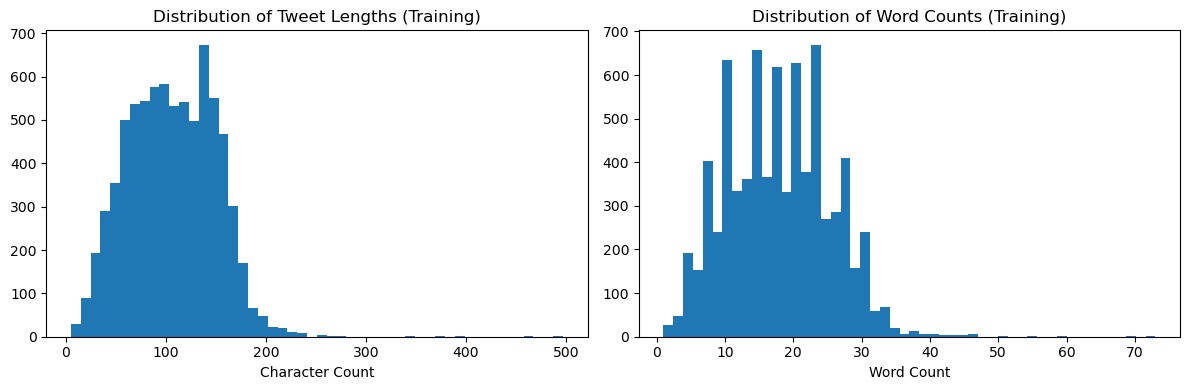

In [7]:
# Class distribution in training set
print("Training Set Class Distribution:")
print(df_train["target"].value_counts(normalize=True))

# Missing values analysis
print("\nMissing Values in Training Set:")
print(df_train.isnull().sum())
print("\nMissing Values in Test Set:")
print(df_test.isnull().sum())

# Basic text statistics using existing text column
print("\nText Statistics (Training Set):")
df_text_stats = pd.DataFrame({
    'Text Length': df_train['text'].str.len(),
    'Word Count': df_train['text'].str.split().str.len()
})
print(df_text_stats.describe())

# Visualize distributions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_train['text'].str.len(), bins=50)
plt.title("Distribution of Tweet Lengths (Training)")
plt.xlabel("Character Count")

plt.subplot(1, 2, 2)
plt.hist(df_train['text'].str.split().str.len(), bins=50)
plt.title("Distribution of Word Counts (Training)")
plt.xlabel("Word Count")

plt.tight_layout()
plt.show()

Clean and save the df

In [75]:
# Clean the text data
df_train['clean_text'] = df_train['text'].str.strip().apply(lambda s: clean(s))
df_test['clean_text'] = df_test['text'].str.strip().apply(lambda s: clean(s))

# Replace original text with cleaned version
df_train['text'] = df_train['clean_text']
df_test['text'] = df_test['clean_text']

# Remove the redundant clean_text column
df_train.drop('clean_text', axis=1, inplace=True)
df_test.drop('clean_text', axis=1, inplace=True)

# Save cleaned data to CSV
df_train.to_csv("Data/train_cleaned.csv", index=False)
df_test.to_csv("Data/test_cleaned.csv", index=False)

In [8]:
print(df_train.head())
print(df_test.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this    #   earthq...   
1   4     NaN      NaN       Forest fire near La Ronge Sask   .    Canada   
2   5     NaN      NaN  All residents asked to    '   shelter in place...   
3   6     NaN      NaN  13,000 people receive    #   wildfires evacuat...   
4   7     NaN      NaN  Just got sent this photo from Ruby    #   Alas...   

   target  word_count  unique_word_count  stop_word_count  url_count  \
0       1          14                 14                6          0   
1       1           8                  8                0          0   
2       1          25                 20               11          0   
3       1           9                  9                1          0   
4       1          18                 16                7          0   

   mean_word_length  char_count  punctuation_count  hashtag_count  \
0          4.071429          73    

Get all words from tweets

In [9]:
# Disaster tweets
disaster_tweets = df_train[df_train['target'] == 1]['text']
disaster_words = ' '.join(disaster_tweets).split()

# Non-disaster tweets
non_disaster_tweets = df_train[df_train['target'] == 0]['text']
non_disaster_words = ' '.join(non_disaster_tweets).split()

Saimon: The following needs to be added on EDA or after tokenization 
1. Identify parts of speech and filter
2. Identify libraries that have some dictionary basis of words and emotional attachment, bring it over, compare tokenization to compare.
3.

Create word clouds

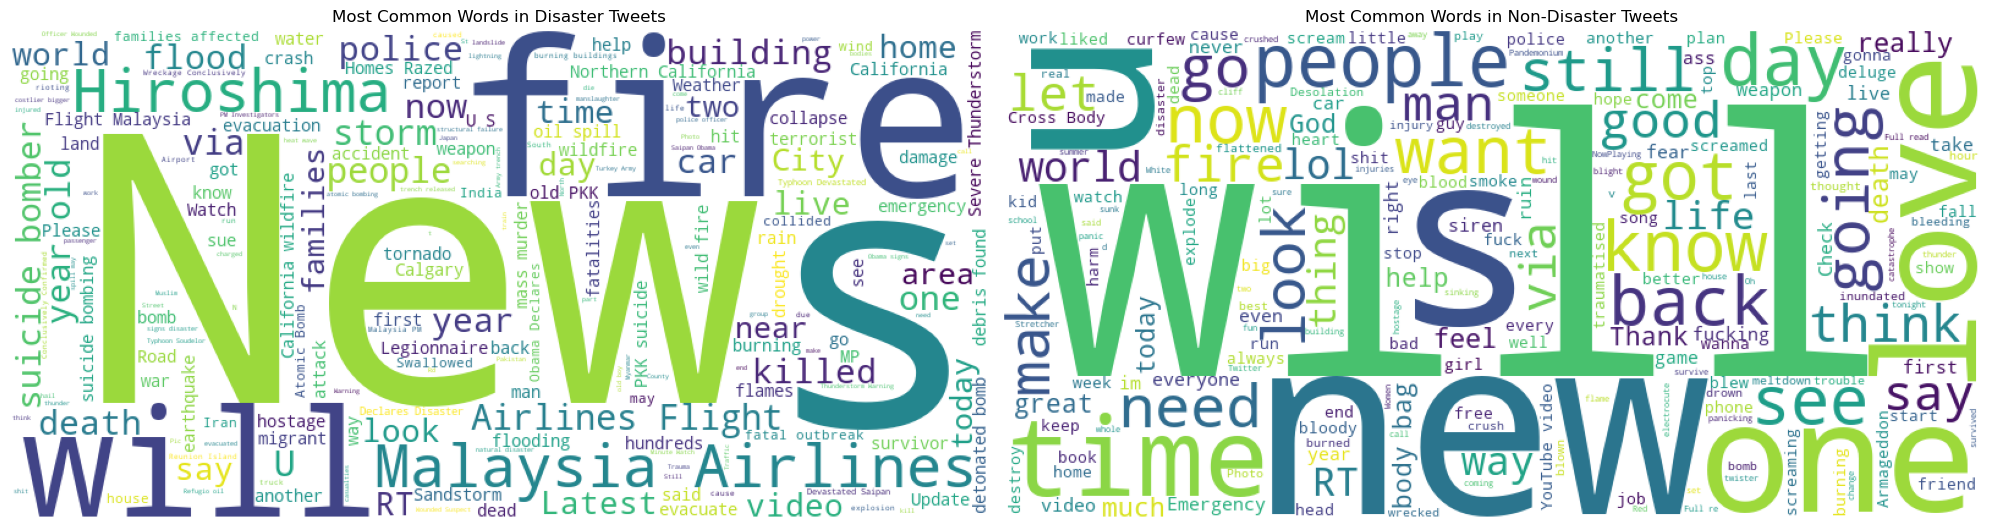

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Disaster tweets word cloud
wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate(' '.join(disaster_words))
ax1.imshow(wordcloud_disaster)
ax1.axis('off')
ax1.set_title('Most Common Words in Disaster Tweets')

# Non-disaster tweets word cloud
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_disaster_words))
ax2.imshow(wordcloud_non_disaster)
ax2.axis('off')
ax2.set_title('Most Common Words in Non-Disaster Tweets')

plt.tight_layout()
plt.show()

Show the most common keywords

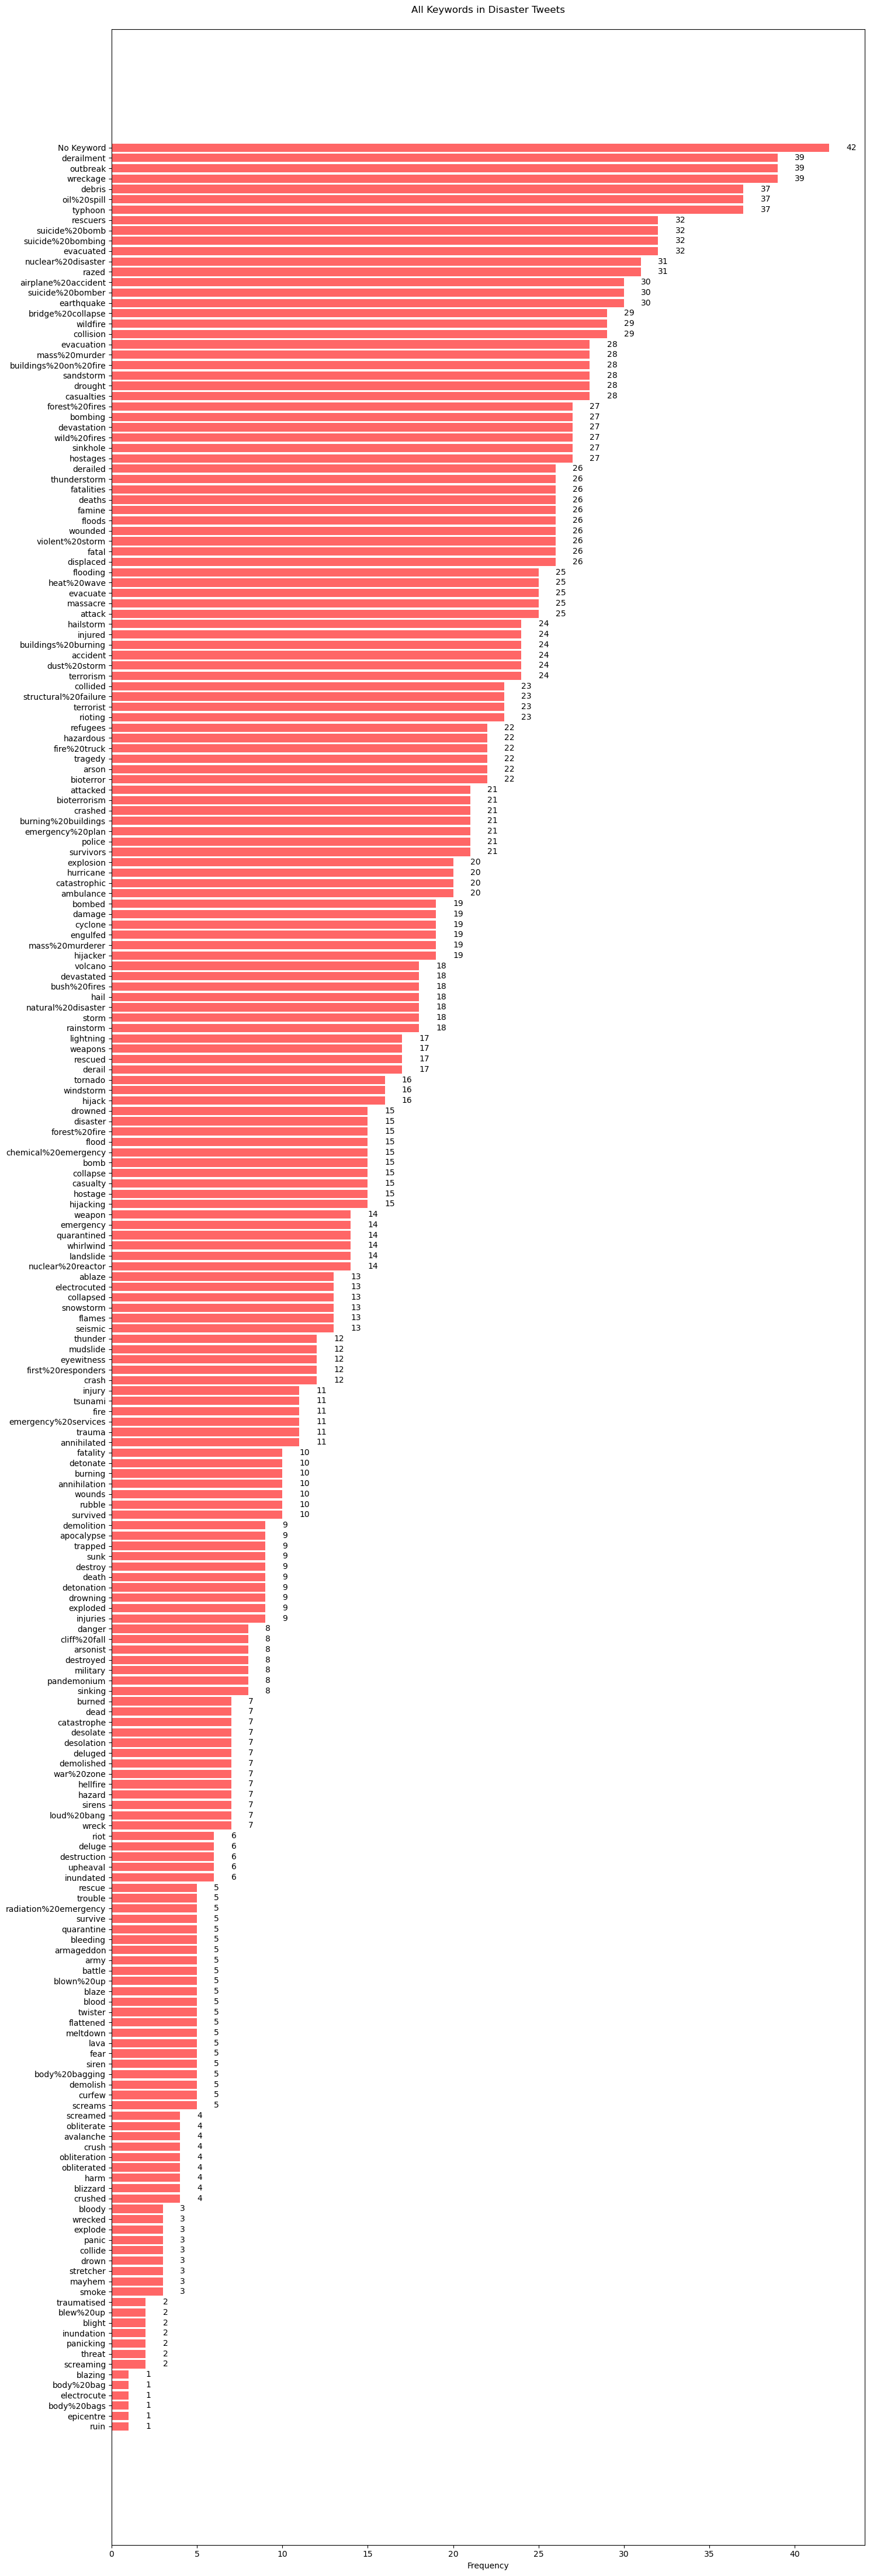


All keywords in Disaster Tweets:
No Keyword: 42
derailment: 39
outbreak: 39
wreckage: 39
debris: 37
oil%20spill: 37
typhoon: 37
rescuers: 32
suicide%20bomb: 32
suicide%20bombing: 32
evacuated: 32
nuclear%20disaster: 31
razed: 31
airplane%20accident: 30
suicide%20bomber: 30
earthquake: 30
bridge%20collapse: 29
wildfire: 29
collision: 29
evacuation: 28
mass%20murder: 28
buildings%20on%20fire: 28
sandstorm: 28
drought: 28
casualties: 28
forest%20fires: 27
bombing: 27
devastation: 27
wild%20fires: 27
sinkhole: 27
hostages: 27
derailed: 26
thunderstorm: 26
fatalities: 26
deaths: 26
famine: 26
floods: 26
wounded: 26
violent%20storm: 26
fatal: 26
displaced: 26
flooding: 25
heat%20wave: 25
evacuate: 25
massacre: 25
attack: 25
hailstorm: 24
injured: 24
buildings%20burning: 24
accident: 24
dust%20storm: 24
terrorism: 24
collided: 23
structural%20failure: 23
terrorist: 23
rioting: 23
refugees: 22
hazardous: 22
fire%20truck: 22
tragedy: 22
arson: 22
bioterror: 22
attacked: 21
bioterrorism: 21
cra

In [29]:
# Get all disaster keywords and their counts, including NaN values
disaster_keywords = df_train[df_train['target'] == 1]['keyword'].value_counts(dropna=False)
disaster_keywords.index = disaster_keywords.index.fillna('No Keyword')

# Create figure for disaster keywords
fig1, ax1 = plt.subplots(figsize=(15, len(disaster_keywords) * 0.2))

# Plot disaster keywords
bars1 = ax1.barh(range(len(disaster_keywords)), disaster_keywords.values, color='red', alpha=0.6)
ax1.set_yticks(range(len(disaster_keywords)))
ax1.set_yticklabels(disaster_keywords.index)
ax1.set_title('All Keywords in Disaster Tweets', pad=20)
ax1.set_xlabel('Frequency')
ax1.invert_yaxis()

# Add count labels on the bars
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{int(width):,}',
             ha='left', va='center')

plt.tight_layout()
plt.show()

# Print the actual counts
print("\nAll keywords in Disaster Tweets:")
for keyword, count in disaster_keywords.items():
    print(f"{keyword}: {count}")

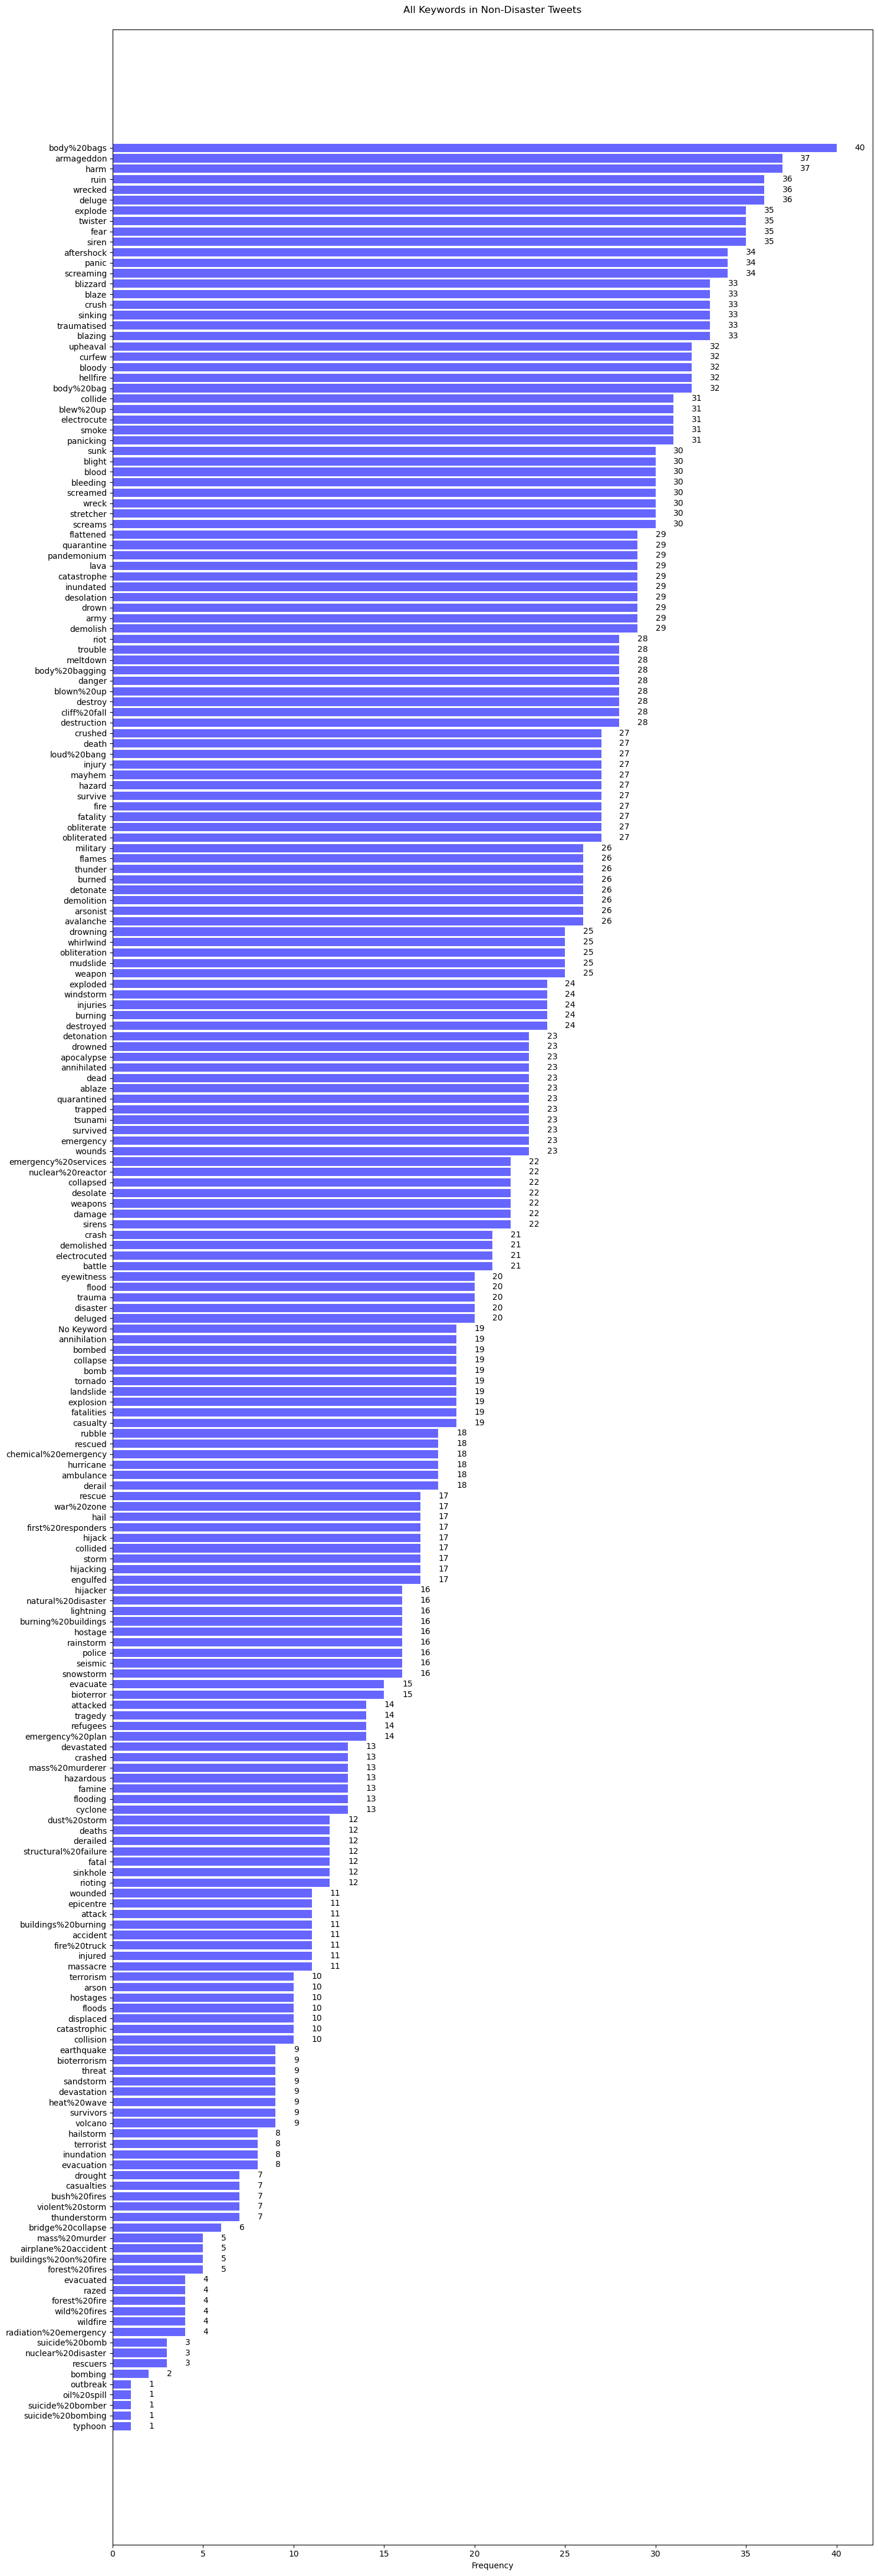

In [31]:
# Get all non-disaster keywords and their counts, including NaN values
non_disaster_keywords = df_train[df_train['target'] == 0]['keyword'].value_counts(dropna=False)
non_disaster_keywords.index = non_disaster_keywords.index.fillna('No Keyword')

# Create figure for non-disaster keywords
fig2, ax2 = plt.subplots(figsize=(15, len(non_disaster_keywords) * 0.2))

# Plot non-disaster keywords
bars2 = ax2.barh(range(len(non_disaster_keywords)), non_disaster_keywords.values, color='blue', alpha=0.6)
ax2.set_yticks(range(len(non_disaster_keywords)))
ax2.set_yticklabels(non_disaster_keywords.index)
ax2.set_title('All Keywords in Non-Disaster Tweets', pad=20)
ax2.set_xlabel('Frequency')
ax2.invert_yaxis()

# Add count labels on the bars
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{int(width):,}',
             ha='left', va='center')

# Adjust layout to remove extra space
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.2, right=0.95)
plt.tight_layout()
plt.show()

Show the most common locations

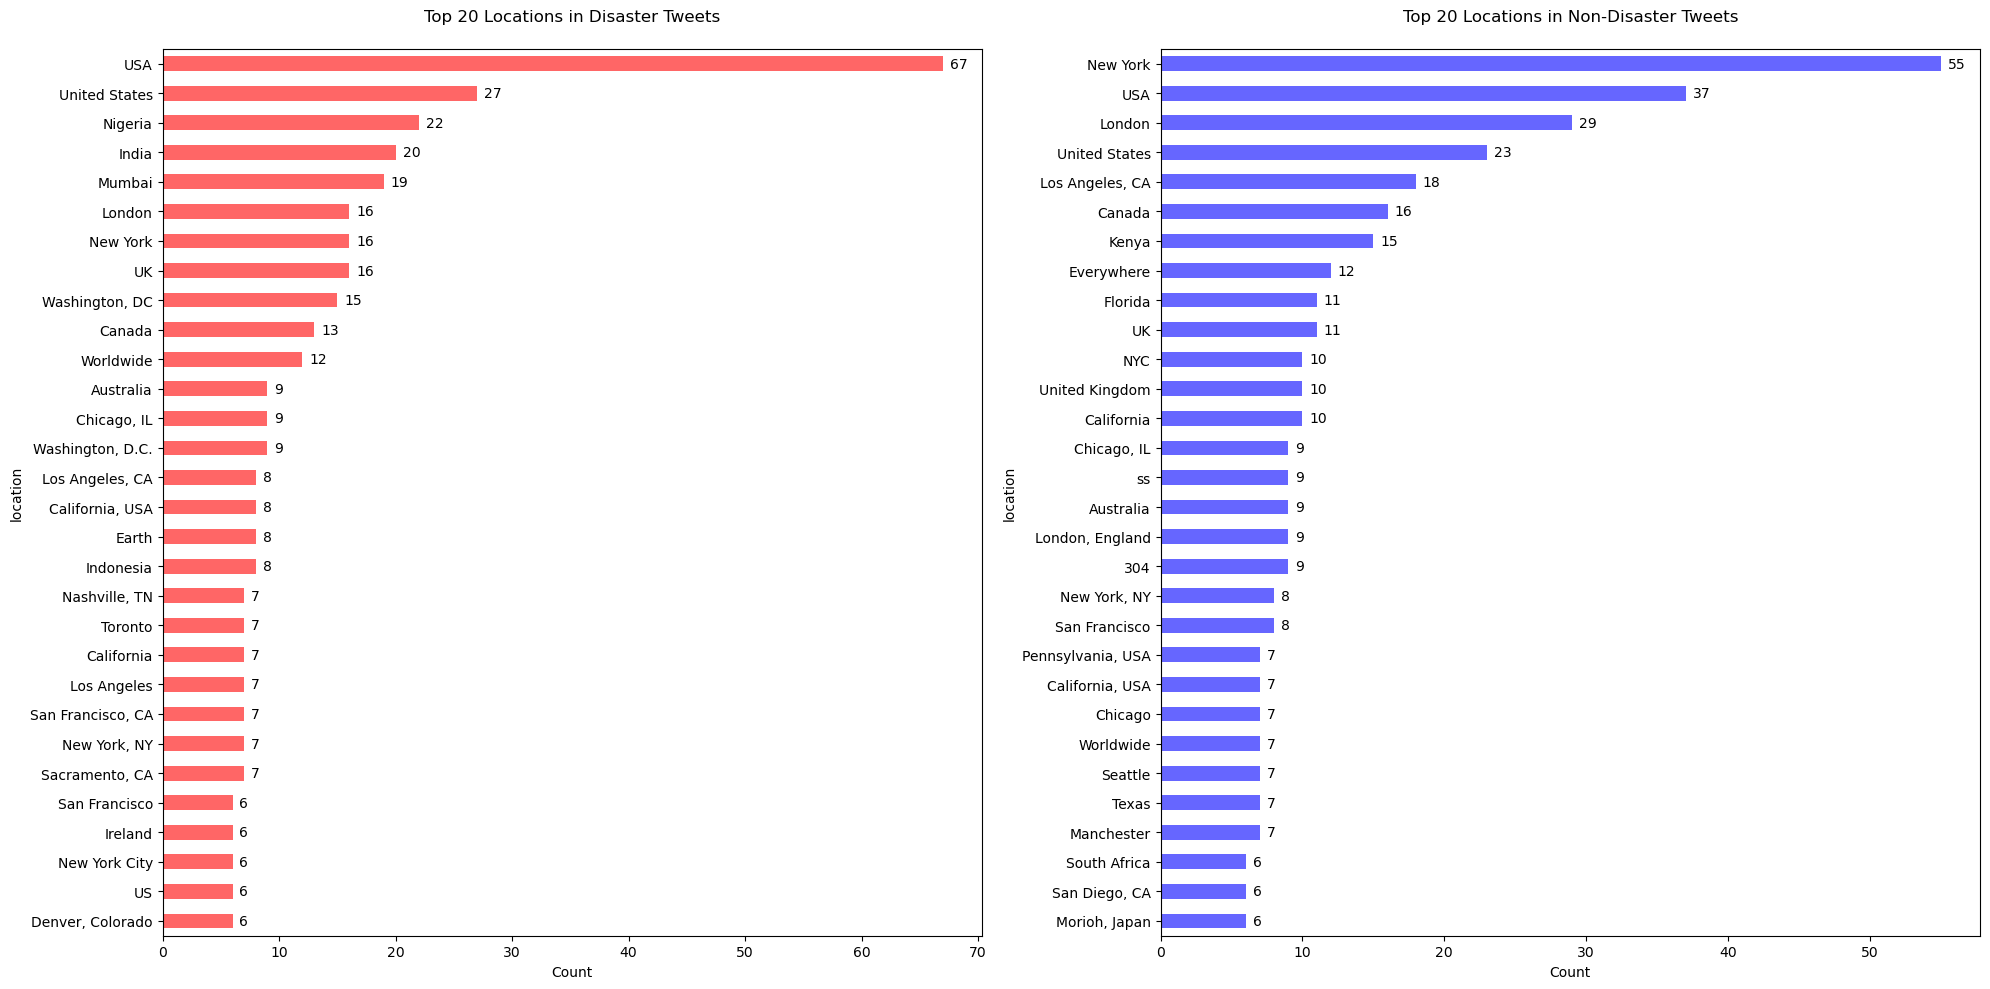

In [32]:
# Get location counts for disaster and non-disaster tweets
disaster_locations = df_train[df_train['target'] == 1]['location'].value_counts().head(30)
non_disaster_locations = df_train[df_train['target'] == 0]['location'].value_counts().head(30)

# Create subplots for location distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot disaster tweet locations
disaster_locations.plot(kind='barh', ax=ax1, color='red', alpha=0.6)
ax1.set_title('Top 20 Locations in Disaster Tweets', pad=20)
ax1.set_xlabel('Count')
ax1.invert_yaxis()

# Plot non-disaster tweet locations
non_disaster_locations.plot(kind='barh', ax=ax2, color='blue', alpha=0.6)
ax2.set_title('Top 20 Locations in Non-Disaster Tweets', pad=20)
ax2.set_xlabel('Count')
ax2.invert_yaxis()

# Add count labels on the bars
for ax in [ax1, ax2]:
    for container in ax.containers:
        ax.bar_label(container, padding=5)

plt.tight_layout()
plt.show()

Location Presence vs Disaster Type

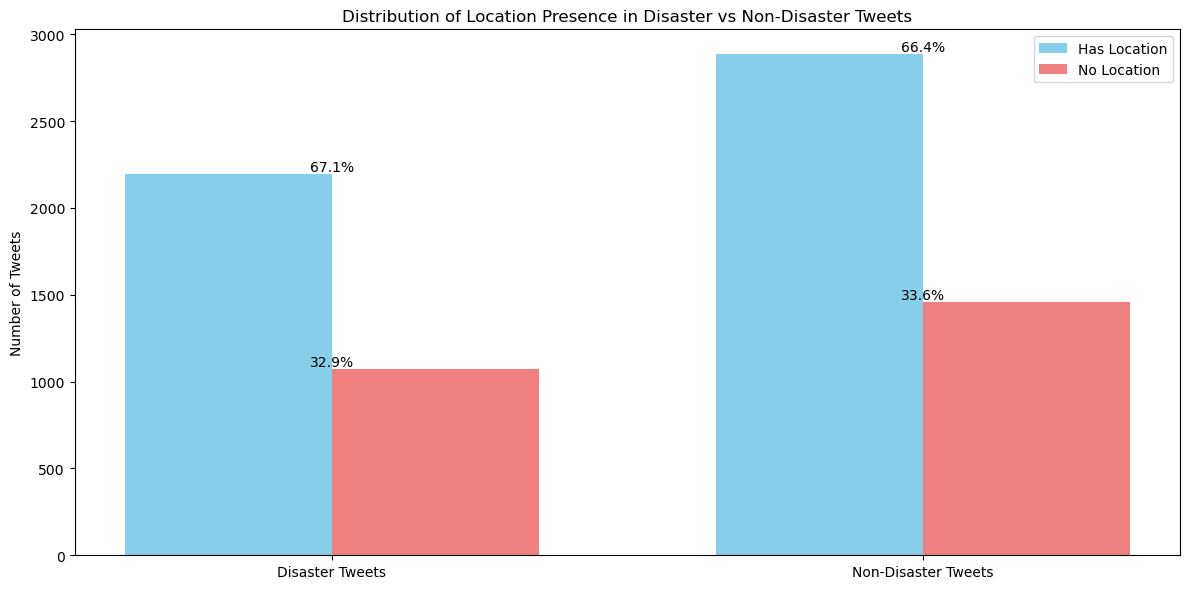

In [33]:
# Create a figure to analyze location presence vs tweet type
plt.figure(figsize=(12, 6))

# Calculate proportions for disaster and non-disaster tweets
has_location_disaster = df_train[(df_train['target'] == 1) & df_train['location'].notna()].shape[0]
no_location_disaster = df_train[(df_train['target'] == 1) & df_train['location'].isna()].shape[0]
has_location_non_disaster = df_train[(df_train['target'] == 0) & df_train['location'].notna()].shape[0]
no_location_non_disaster = df_train[(df_train['target'] == 0) & df_train['location'].isna()].shape[0]

# Create the grouped bar plot
x = np.arange(2)
width = 0.35

plt.bar(x - width/2, [has_location_disaster, has_location_non_disaster], width, 
        label='Has Location', color='skyblue')
plt.bar(x + width/2, [no_location_disaster, no_location_non_disaster], width, 
        label='No Location', color='lightcoral')

# Customize the plot
plt.xticks(x, ['Disaster Tweets', 'Non-Disaster Tweets'])
plt.ylabel('Number of Tweets')
plt.title('Distribution of Location Presence in Disaster vs Non-Disaster Tweets')
plt.legend()

# Add percentage labels on top of each bar
def add_percentage_labels(values, x_pos):
    total = sum(values)
    for i, v in enumerate(values):
        percentage = (v / total) * 100
        plt.text(x_pos, v, f'{percentage:.1f}%', 
                ha='center', va='bottom')

add_percentage_labels([has_location_disaster, no_location_disaster], x[0])
add_percentage_labels([has_location_non_disaster, no_location_non_disaster], x[1])

plt.tight_layout()
plt.show()

### Meta Features Analysis

Let's extract meta features that could help identify disaster tweets:
- word_count: number of words in text
- unique_word_count: number of unique words in text
- stop_word_count: number of stop words in text
- url_count: number of urls in text
- mean_word_length: average character count in words
- char_count: number of characters in text
- punctuation_count: number of punctuations in text
- hashtag_count: number of hashtags (#) in text
- mention_count: number of mentions (@) in text

In [11]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

def extract_meta_features(df):
    """Extract meta features from the text column of a dataframe."""
    
    # Get stop words
    stop_words = set(stopwords.words('english'))
    
    # Create meta features
    meta_features = pd.DataFrame()
    
    # Basic word counts
    meta_features['word_count'] = df['text'].str.split().str.len()
    
    # Unique word counts
    meta_features['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).lower().split())))
    
    # Stop word count
    meta_features['stop_word_count'] = df['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in stop_words]))
    
    # URL count
    meta_features['url_count'] = df['text'].str.count(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+')
    
    # Mean word length
    meta_features['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
    
    # Character count
    meta_features['char_count'] = df['text'].str.len()
    
    # Punctuation count
    meta_features['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
    # Hashtag count
    meta_features['hashtag_count'] = df['text'].str.count('#')
    
    # Mention count
    meta_features['mention_count'] = df['text'].str.count('@')
    
    return meta_features

Extract and normalize meta features for both train and test sets

In [23]:
# Extract meta features
train_meta = extract_meta_features(df_train)
test_meta = extract_meta_features(df_test)

# Normalize meta features
meta_columns = train_meta.columns.tolist()
scaler = StandardScaler()
train_meta[meta_columns] = scaler.fit_transform(train_meta[meta_columns])
test_meta[meta_columns] = scaler.transform(test_meta[meta_columns])

Add normalized meta features to the original dataframes

In [25]:
for column in meta_columns:
    df_train[column] = train_meta[column]
    df_test[column] = test_meta[column]

Feature Distribution Analysis
Comparing distributions of meta features across classes and datasets:
- Left: Disaster vs Non-Disaster tweets
- Right: Training vs Test set distributions

In [27]:
# Display summary statistics of meta features
print("\nMeta Features Summary (Training Set):")
print(train_meta.describe())


Meta Features Summary (Training Set):
         word_count  unique_word_count  stop_word_count  url_count  \
count  7.613000e+03       7.613000e+03     7.613000e+03     7613.0   
mean  -1.777990e-16      -9.333282e-18     3.639980e-17        0.0   
std    1.000066e+00       1.000066e+00     1.000066e+00        0.0   
min   -2.253254e+00      -2.455524e+00    -1.342006e+00        0.0   
25%   -7.911994e-01      -7.831105e-01    -8.115032e-01        0.0   
50%    6.285180e-03       5.309633e-02    -2.810001e-01        0.0   
75%    8.037697e-01       7.220618e-01     5.147546e-01        0.0   
max    7.316560e+00       3.565165e+00     4.493528e+00        0.0   

       mean_word_length    char_count  punctuation_count  hashtag_count  \
count      7.613000e+03  7.613000e+03       7.613000e+03   7.613000e+03   
mean       9.501281e-16  1.082661e-16       8.213288e-17   4.759974e-17   
std        1.000066e+00  1.000066e+00       1.000066e+00   1.000066e+00   
min       -3.083813e+00 -2.330

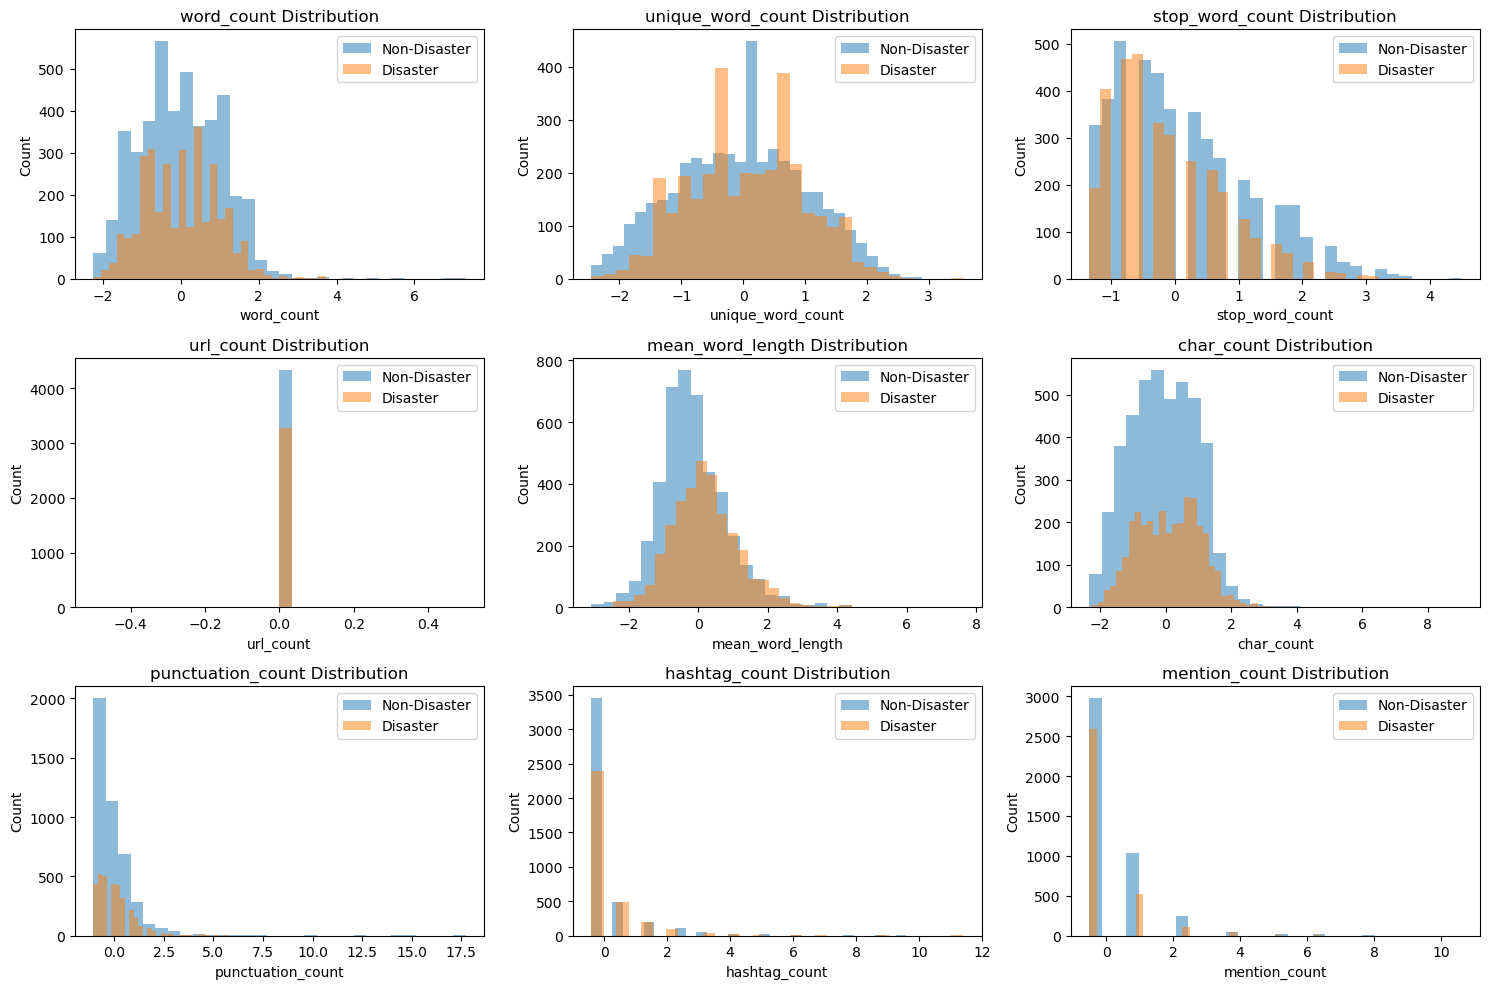

In [28]:
# Visualize meta feature distributions
plt.figure(figsize=(15, 10))

for i, column in enumerate(train_meta.columns, 1):
    plt.subplot(3, 3, i)
    
    if df_train['target'].nunique() > 1:
        for target in [0, 1]:
            data = df_train[df_train['target'] == target][column]
            plt.hist(data, bins=30, alpha=0.5, label=f"{'Disaster' if target == 1 else 'Non-Disaster'}")
        plt.legend()
    
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Data Preprocessing and Model Setup

### Hyperparameters
- **BATCH_SIZE = 32**: Standard batch size for transformer models
- **VAL_SPLIT = 0.2**: 80% training, 20% validation split
- **MAX_LENGTH = 160**: Maximum tweet length (in tokens)
- **MODEL_NAME = "distilbert-base-uncased"**: Pre-trained model we'll fine-tune

### Data Processing Pipeline
1. Split data into train/validation sets
2. Convert to HuggingFace Datasets format
3. Tokenize text using DistilBERT tokenizer
4. Create PyTorch DataLoaders

The tokenization process converts text into numbers that the model can understand:
- Splits text into tokens (subwords)
- Adds special tokens ([CLS], [SEP])
- Pads sequences to same length
- Creates attention masks

Hyperparameters

In [29]:
BATCH_SIZE = 32        # Standard batch size for transformer models
VAL_SPLIT = 0.2        # 80% training, 20% validation split
MAX_LENGTH = 160       # Maximum tweet length (in tokens)
MODEL_NAME = "distilbert-base-uncased"  # Pre-trained model we'll fine-tune

Split data into train/validation sets

In [30]:
from sklearn.model_selection import train_test_split

# stratified split
train_df, val_df = train_test_split(
    df_train,
    test_size=VAL_SPLIT,
    random_state=42,
    stratify=df_train["target"],
)

Convert to HuggingFace Datasets format

In [31]:
# Wrap pandas DataFrames in HF Dataset
train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(df_test)

Tokenize text using DistilBERT tokenizer

In [32]:
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

# Tokenizing function
def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
    )
    
# Apply tokenization
train_ds = train_ds.map(tokenize_batch, batched=True)
val_ds   = val_ds.map(tokenize_batch, batched=True)
test_ds  = test_ds.map(tokenize_batch, batched=True)

print("Train columns:", train_ds.column_names)
print("Validation columns:", val_ds.column_names)
print("Test columns:", test_ds.column_names)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

Train columns: ['id', 'keyword', 'location', 'text', 'target', 'word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count', 'length', '__index_level_0__', 'input_ids', 'attention_mask']
Validation columns: ['id', 'keyword', 'location', 'text', 'target', 'word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count', 'length', '__index_level_0__', 'input_ids', 'attention_mask']
Test columns: ['id', 'keyword', 'location', 'text', 'word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count', 'length', 'input_ids', 'attention_mask']


Format DataLoaders

In [33]:
# Columns we’d like to drop
drop_cols = ["__index_level_0__", "length"]

# Remove from train & val
train_ds = train_ds.remove_columns([c for c in drop_cols if c in train_ds.column_names])
val_ds   = val_ds.remove_columns(  [c for c in drop_cols if c in val_ds.column_names])
test_ds  = test_ds.remove_columns( [c for c in drop_cols if c in test_ds.column_names])

# Rename 'target' → 'labels' (only train/val have it)
if "target" in train_ds.column_names:
    train_ds = train_ds.rename_column("target", "labels")
if "target" in val_ds.column_names:
    val_ds   = val_ds.rename_column("target", "labels")

Build DataLoaders

In [34]:
def collate_fn(examples):
    """Collate function that handles batching of examples, including meta features"""
    try:
        input_ids = torch.stack([torch.tensor(x['input_ids']) for x in examples])
        attention_mask = torch.stack([torch.tensor(x['attention_mask']) for x in examples])
        
        batch = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
        }
        
        # Add meta features
        meta_columns = [
            'word_count', 'unique_word_count', 'stop_word_count', 'url_count',
            'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count'
        ]
        meta = torch.stack([
            torch.tensor([float(x[c]) for c in meta_columns], dtype=torch.float32)
            for x in examples
        ])
        batch['meta'] = meta

        if 'labels' in examples[0]:
            batch['labels'] = torch.tensor([x['labels'] for x in examples])
        
        return batch
    except Exception as e:
        print(f"Error in collate_fn: {str(e)}")
        raise e

In [44]:
# DataLoader settings
dataloader_kwargs = {
    'batch_size': BATCH_SIZE,
    'num_workers': 0,
    'collate_fn': collate_fn,
    'pin_memory': False,
    'drop_last': False,
    'persistent_workers': False,
}

# Initialize DataLoaders
train_loader = DataLoader(train_ds, shuffle=True, **dataloader_kwargs)
val_loader = DataLoader(val_ds, shuffle=False, **dataloader_kwargs)
test_loader = DataLoader(test_ds, shuffle=False, **dataloader_kwargs)

# Model Training

### Training Configuration
- **Model**: DistilBERT with binary classification head
- **Loss**: CrossEntropyLoss (standard for classification)
- **Optimizer**: AdamW with learning rate 1e-5
- **Epochs**: 2 full passes through the training data

### Training Process
For each epoch, we:
1. Set model to training mode
2. Process mini-batches of data
3. Compute loss and gradients
4. Update model parameters
5. Track and display average loss

### What to Watch For
- Decreasing loss values indicate learning
- Too rapid decrease might suggest overfitting
- Stable loss suggests good learning rate

The training loop includes proper handling of:
- GPU acceleration (if available)
- Gradient computation and updates
- Batch processing
- Loss tracking


Model initialization

In [45]:
def build_distilbert_with_meta(model_name, meta_dim, num_labels=2, dropout=0.2):
    bert = DistilBertModel.from_pretrained(model_name)
    classifier = nn.Linear(bert.config.hidden_size + meta_dim, num_labels)
    drop = nn.Dropout(dropout)
    
    model = nn.Module()
    model.bert = bert
    model.classifier = classifier
    model.drop = drop

    def forward(self, input_ids, attention_mask, meta, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        combined = torch.cat([pooled_output, meta], dim=1)
        logits = self.classifier(self.drop(combined))
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return type('obj', (object,), {'loss': loss, 'logits': logits})()
    
    model.forward = types.MethodType(forward, model)
    return model

In [46]:
import types

meta_dim = 9  # Number of meta features
model = build_distilbert_with_meta(MODEL_NAME, meta_dim=meta_dim, num_labels=2)

# Use DirectML for AMD GPU, fallback to CPU if not available
try:
    import torch_directml
    device = torch_directml.device()
except ImportError:
    device = torch.device("cpu")

model.to(device)

Module(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

Optimizer and scheduler

In [47]:
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 2
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

Training Loop

In [49]:
best_f1 = 0.0
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            meta=batch['meta'],
            labels=batch['labels']
        )
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()
        total_loss += loss.item()
    print(f"Epoch {epoch} — avg loss: {total_loss/len(train_loader):.4f}")

Epoch 1:   0%|          | 0/191 [00:00<?, ?it/s]

c:\Users\samin\miniconda3\envs\nlp-env\lib\site-packages\torch\optim\adamw.py:529: UserWarning: The operator 'aten::lerp.Scalar_out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)


Epoch 1 — avg loss: 0.4796


Epoch 2:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch 2 — avg loss: 0.3701


Validation

In [51]:
model.eval()
true_labels, pred_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                meta=batch['meta']
        )
        preds = torch.argmax(outputs.logits, dim=1)
        true_labels.extend(batch['labels'].cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
    val_f1 = f1_score(true_labels, pred_labels, average='weighted')
    val_acc = accuracy_score(true_labels, pred_labels)
    print(f"Validation — F1: {val_f1:.4f} | Accuracy: {val_acc:.4f}")

Validation — F1: 0.8445 | Accuracy: 0.8450


# Model Evaluation

### Evaluation Metrics
We use several metrics to assess model performance:

1. **Confusion Matrix**
   - Shows True Positives, False Positives, True Negatives, False Negatives
   - Helps visualize where model makes mistakes

2. **F1 Score**
   - Harmonic mean of precision and recall
   - Balances false positives and false negatives
   - Particularly important for imbalanced datasets

### Prediction Process
The `get_predictions` function:
1. Sets model to evaluation mode
2. Disables gradient computation
3. Processes batches of data
4. Returns both true labels and predicted probabilities

### Visualization
The confusion matrix plot shows:
- Correct predictions on diagonal
- Errors off-diagonal
- Color intensity indicates frequency
- Labels for easy interpretation

In [54]:
def get_predictions(loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            meta = batch['meta'].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask, meta=meta).logits
            probs = torch.softmax(logits, dim=-1)

            all_preds.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    return (
        np.concatenate(all_labels, axis=0),
        np.concatenate(all_preds, axis=0),
    )


def display_confusion_matrix(y_true, y_pred_probs, dataset_name):
    y_pred = np.argmax(y_pred_probs, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Disaster", "Disaster"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix — {dataset_name}")
    plt.show()

    # F1 score from sklearn instead of manual formula (more reliable)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"{dataset_name} F1 score: {f1:.2f}\n")

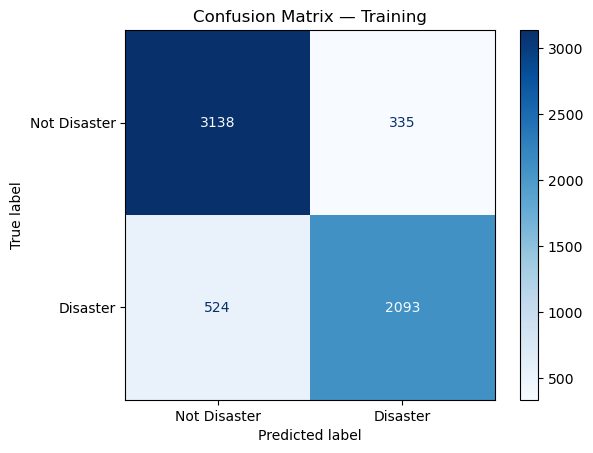

Training F1 score: 0.86



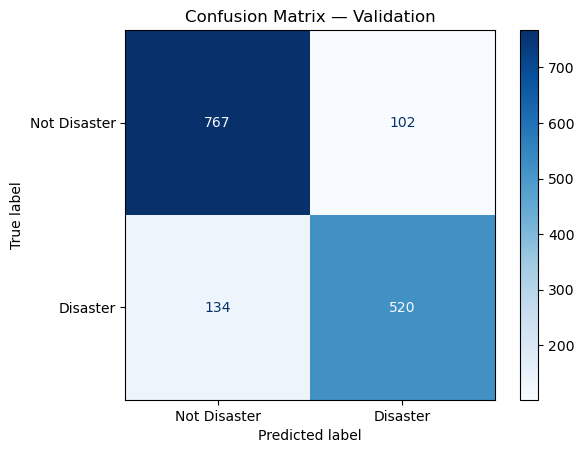

Validation F1 score: 0.84



In [55]:
y_train, p_train = get_predictions(train_loader)
display_confusion_matrix(y_train, p_train, "Training")

y_val, p_val = get_predictions(val_loader)
display_confusion_matrix(y_val, p_val, "Validation")
